# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [92]:
!pip install pydrive
!pip install gensim
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1cZS7OUXVft4KTZ1AzZPu95hSgWzu3aC8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('final.sqlite')

In [0]:
# loading libraries and data

%matplotlib inline

import sqlite3                          # for sql database
import pandas as pd
import numpy as np
import nltk                             # nltk:- Natural Language Processing Toolkit
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import pickle
def saveindisk(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromdisk(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

con = sqlite3.connect("final.sqlite")

# Filtering only positive and negative reviews that is
# not taking into consideration those reviews with score = 3
df = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [95]:
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [96]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [97]:
df.shape

(364171, 13)

In [98]:
df['Score'].size

364171

In [99]:
# Taking Sample Datapoints
n_samples = 15000
df_sample = df.sample(n_samples)
df_sample.sort_values('Time', inplace=True) #Sorting with respect to time
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169304,212495,230309,B00004RYGX,A34NBH479RB0E,"""dmab6395""",0,1,Positive,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",b'thought movi funni michael keaton beetlejuic...,b'thought movie funny michael keaton beetlejui...
117266,137933,149701,B00006L2ZT,A2STZ646VQE8QI,anomalogue,1,3,Positive,1036540800,This is the best Camper Van Beethoven,This is a beautiful repackaging of Camper Van...,b'beauti repackag camper van beethoven first t...,b'beautiful repackaging camper van beethovens ...
169278,212469,230282,B00004RYGX,A3ICHEO78NFE4Y,Rick D. Barszcz,1,2,Positive,1042416000,Just plain fun!,I recently saw the DVD 5.1 version of this fil...,b'recent saw dvd version film excel pictur qua...,b'recently saw dvd version film excellent pict...
276398,381856,412884,B0000CDAY2,A2QCB2GF8NLJCC,S. Scott,0,0,Positive,1071792000,Just like being in Maine,"I recently received the Maine Lobster Salad, c...",b'recent receiv main lobster salad complet aut...,b'recently received maine lobster salad comple...
236007,312396,338208,B00013EWL4,A266IWDX3A2FZT,Christopher L. Dolmetsch,2,2,Positive,1076371200,A Great Find!,It's rare to find a condiment with both sweetn...,b'rare find condiment sweet tart combin well f...,b'rare find condiment sweetness tartness combi...


# Applying the KNN Models on the different Vectorizing Techniques


## Bag of Word(BOW)

In [0]:
from sklearn.model_selection import train_test_split

uni_gram = CountVectorizer() # Text to Uni gram Vectors
uni_gram_vectors = uni_gram.fit_transform(df_sample['CleanedText'].values)

In [101]:
uni_gram_vectors.shape

(15000, 15673)

In [0]:
from  sklearn import  preprocessing
uni_gram_vectors_norm = preprocessing.normalize(uni_gram_vectors)

In [0]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report

def batch_predict(clf, X, batch_size=1000):
    n = X.shape[0]
    pred = np.empty(n, dtype=object)
    i = 0
    while i < n:
        last = min(i+batch_size, n)
        pred[i:last] = clf.predict(X[i:last, :])
        i += batch_size
        
    return pred

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(uni_gram_vectors_norm,df_sample['Score'].values,
                                                   test_size=0.3, shuffle=False)

In [0]:
neigh_near = 100
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = []
mylist = list(range(0, 101))
neighbors = list(filter(lambda x: x % 2 != 0, mylist))

for k in neighbors:
    tmp = []
    for train, cv in tscv.split(X_train):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[train], y_train[train])
        tmp.append(knn.score(X_train[cv], y_train[cv]) * 100)
    tmp = np.array(tmp)
    cv_scores.append(tmp.mean())

In [106]:
MSE = [1 - x for x in cv_scores] # changing to misclassification error
optimal_k = neighbors[MSE.index(min(MSE))] # determining best k
print('The optimal number of neighbors is %d' %optimal_k)

The optimal number of neighbors is 9


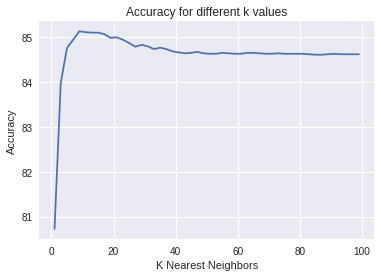

In [107]:
plt.plot(np.arange(1, neigh_near, 2), cv_scores)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.show()

In [108]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 84.844%


# Bi-gram

In [109]:
bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(df_sample['CleanedText'].values)
bi_gram_vectors.shape

(15000, 320810)

In [0]:
bi_gram_vectors_norm = preprocessing.normalize(bi_gram_vectors)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(bi_gram_vectors_norm,df_sample['Score'].values,
                                                   test_size=0.3, shuffle=False)

In [0]:
neigh_near = 100
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = []
mylist = list(range(0, 101))
neighbors = list(filter(lambda x: x % 2 != 0, mylist))

for k in neighbors:
    tmp = []
    for train, cv in tscv.split(X_train):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[train], y_train[train])
        tmp.append(knn.score(X_train[cv], y_train[cv]) * 100)
    tmp = np.array(tmp)
    cv_scores.append(tmp.mean())

In [166]:
MSE = [1 - x for x in cv_scores] # changing to misclassification error
optimal_k = neighbors[MSE.index(min(MSE))] # determining best k
print('The optimal number of neighbors is %d' %optimal_k)

The optimal number of neighbors is 15


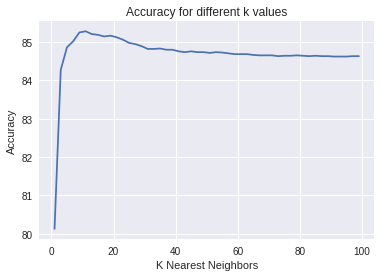

In [114]:
plt.plot(np.arange(1, neigh_near, 2), cv_scores)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.show()

In [115]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 84.956%


# tf-idf

TFIDF = TF x IDF

In [0]:
tfidf = TfidfVectorizer(ngram_range=(1, 2)) 
tfidf_vectors = tfidf.fit_transform(df_sample['CleanedText'].values)

In [0]:
tfidf_vectors_norm = preprocessing.normalize(tfidf_vectors)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors_norm,df_sample['Score'].values,
                                                   test_size=0.3, shuffle=False)

In [0]:
neigh_near = 100
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = []
mylist = list(range(0, 101))
neighbors = list(filter(lambda x: x % 2 != 0, mylist))

for k in neighbors:
    tmp = []
    for train, cv in tscv.split(X_train):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[train], y_train[train])
        tmp.append(knn.score(X_train[cv], y_train[cv]) * 100)
    tmp = np.array(tmp)
    cv_scores.append(tmp.mean())

In [120]:
MSE = [1 - x for x in cv_scores] # changing to misclassification error
optimal_k = neighbors[MSE.index(min(MSE))] # determining best k
print('The optimal number of neighbors is %d' %optimal_k)

The optimal number of neighbors is 9


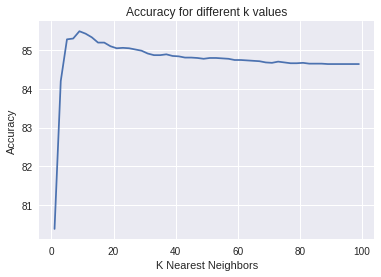

In [121]:
plt.plot(np.arange(1, neigh_near, 2), cv_scores)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.show()

In [122]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 84.889%


# Avg Word2Vec

In [0]:
from sklearn.base import TransformerMixin, BaseEstimator
from gensim.models import Word2Vec
class w2v(TransformerMixin, BaseEstimator):

    def __init__(self, size=100, alpha=0.025, window=5, min_count=10, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=1, hs=0, negative=5, cbow_mean=1, iter=10, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000):
        """
        Sklearn wrapper for Word2Vec model. See gensim.models.Word2Vec for parameter details.
        """
        self.model = None
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words

    def fit(self, X, y=None):
        """
        Fit the model according to the given training data.
        Calls gensim.models.Word2Vec
        """
        X_tokenized = X.apply(lambda sent: sent.split())
        
        self.model = Word2Vec(
            sentences=X_tokenized, size=self.size, alpha=self.alpha,
            window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
            sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
            sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean, 
            iter=self.iter, null_word=self.null_word, trim_rule=self.trim_rule,
            sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
        )
        return self

    def transform(self, X):
        return X.apply(self.avg_word_vector)
    
    def avg_word_vector(self, sent):
        """
        Returns an average word vector 
        from list of words
        if words are not in the wordvector
        vocabulary or in wordlist is 
        empty then returns a zero vector
        """
        word_list = sent.split()
        sent_vec = np.zeros(self.size)
        word_cnt = 0
        for word in word_list:
            try:
                vec = self.model.wv[word]
                sent_vec += vec
                word_cnt += 1
            except KeyError:
                pass
        if word_cnt != 0:
            sent_vec /= word_cnt
        return pd.Series(sent_vec)
    
    def most_similar(self, word):
        return self.model.wv.most_similar(word)
    
    def vocabulary(self):
        """
        Returns a Dataframe with 
        word as index and rows as vectors
        """
        # build a list of the terms, integer indices,
        # and term counts from the word2vec model vocabulary
        ordered_vocab = [(term, voc.index, voc.count)
                         for term, voc in self.model.wv.vocab.items()]

        # sort by the term counts, so the most common terms appear first
        ordered_vocab = sorted(ordered_vocab, key=lambda k : k[2], reverse=True)

        # unzip the terms, integer indices, and counts into separate lists
        ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

        # create a DataFrame with the word vectors as data,
        # and the terms as row labels
        wordvectors = pd.DataFrame(self.model.wv.vectors_norm[term_indices, :],
                                    index=ordered_terms)

        return wordvectors

In [124]:
w2v_model = w2v()

w2v_features = w2v_model.fit_transform(df_sample['Text'])
w2v_features.shape

(15000, 100)

In [125]:
np.any(np.isnan(w2v_features))

False

In [0]:
avg_w2v_norm = preprocessing.normalize(w2v_features)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(avg_w2v_norm,df_sample['Score'].values,
                                                   test_size=0.3, shuffle=False)

In [0]:
neigh_near = 100
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = []
mylist = list(range(0, 101))
neighbors = list(filter(lambda x: x % 2 != 0, mylist))

for k in neighbors:
    tmp = []
    for train, cv in tscv.split(X_train):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[train], y_train[train])
        tmp.append(knn.score(X_train[cv], y_train[cv]) * 100)
    tmp = np.array(tmp)
    cv_scores.append(tmp.mean())

In [161]:
MSE = [1 - x for x in cv_scores] # changing to misclassification error
optimal_k = neighbors[MSE.index(min(MSE))] # determining best k
print('The optimal number of neighbors is %d' %optimal_k)

The optimal number of neighbors is 15


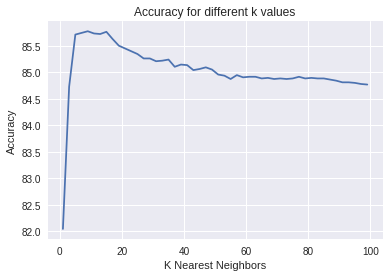

In [130]:
plt.plot(np.arange(1, neigh_near, 2), cv_scores)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.show()

In [131]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 85.311%


# Tf-idf W2Vec

In [0]:
from sklearn.base import TransformerMixin, BaseEstimator
from gensim.models import Word2Vec
class tfidfw2v(TransformerMixin, BaseEstimator):

    def __init__(self, size=100, alpha=0.025, window=5, min_count=10, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=1, hs=0, negative=5, cbow_mean=1, iter=10, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, tfidf_params ={}):
        
        # Sklearn wrapper for Word2Vec model. See gensim.models.Word2Vec for parameter details.
        self.w2v_model = None
        self.tfidf_model = TfidfVectorizer(**tfidf_params)
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words

    def fit(self, X, y=None):
        
        # Fit the model according to the given training data.
        # Calls gensim.models.Word2Vec
        
        X_tokenized = X.apply(lambda sent: sent.split())
        
        self.tfidf_model.fit(X)
        
        self.w2v_model = Word2Vec(
            sentences=X_tokenized, size=self.size, alpha=self.alpha,
            window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
            sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
            sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean, 
            iter=self.iter, null_word=self.null_word, trim_rule=self.trim_rule,
            sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
        )
        return self

    def transform(self, X):
        return X.apply(self.tfidf_w2v)
    
    def tfidf_w2v(self, sent):
        """
        returns a tf-idf word vector of 
        sentence.
        Word list should be a pd.Series
        with name attribute as index for
        finding the weight of the word from
        tfidf features
        """
        tfidf_feature = self.tfidf_model.transform([sent])
        sent_vec = np.zeros(self.size)
        weight_sum = 0
        for word in sent.split():
            try:
                vec = self.w2v_model.wv[word]
                index = self.tfidf_model.vocabulary_[word]
                weight = tfidf_feature[0, index]
                sent_vec += weight * vec
                weight_sum += weight
            except KeyError:
                pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        return pd.Series(sent_vec)
    
    def most_similar(self, word):
        return self.model.wv.most_similar(word)
    
    def vocabulary(self):
        """
        Returns a sorted dataframe (by frequency)
        with words as index and vector as rows
        """
        
        # build a list of the terms, integer indices and term counts from the word2vec model vocabulary
        ordered_vocab = [(term, voc.index, voc.count)
                         for term, voc in self.w2v_model.wv.vocab.items()]

        # sort by the term counts, so the most common terms appear first
        ordered_vocab = sorted(ordered_vocab, key=lambda k : k[2], reverse=True)

        # unzip the terms, integer indices, and counts into separate lists
        ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

        # create a DataFrame with the word vectors as data and the terms as row labels
        wordvectors = pd.DataFrame(self.w2v_model.wv.vectors_norm[term_indices, :],
                                    index=ordered_terms)

        return wordvectors

In [133]:
tfidf_w2v_model = tfidfw2v()

tfidf_w2v_features = tfidf_w2v_model.fit_transform(df_sample['Text'])
tfidf_w2v_features.shape

(15000, 100)

In [134]:
np.any(np.isnan(tfidf_w2v_features))

False

In [0]:
tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_features)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample['Score'].values,
                                                   test_size=0.3, shuffle=False)

In [0]:
neigh_near = 100
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = []
mylist = list(range(0, 101))
neighbors = list(filter(lambda x: x % 2 != 0, mylist))

for k in neighbors:
    tmp = []
    for train, cv in tscv.split(X_train):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[train], y_train[train])
        tmp.append(knn.score(X_train[cv], y_train[cv]) * 100)
    tmp = np.array(tmp)
    cv_scores.append(tmp.mean())

In [155]:
MSE = [1 - x for x in cv_scores] # changing to misclassification error
optimal_k = neighbors[MSE.index(min(MSE))] # determining best k
print('The optimal number of neighbors is %d' %optimal_k)

The optimal number of neighbors is 15


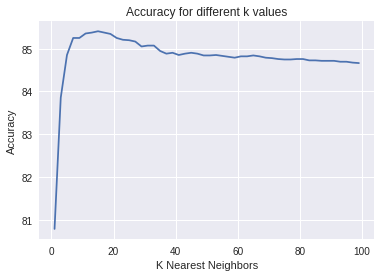

In [139]:
plt.plot(np.arange(1, neigh_near, 2), cv_scores)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.show()

In [140]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 84.689%


# Conclusion:-
* Avg W2Vec gives the best result in classifying the reviews as positive or negative

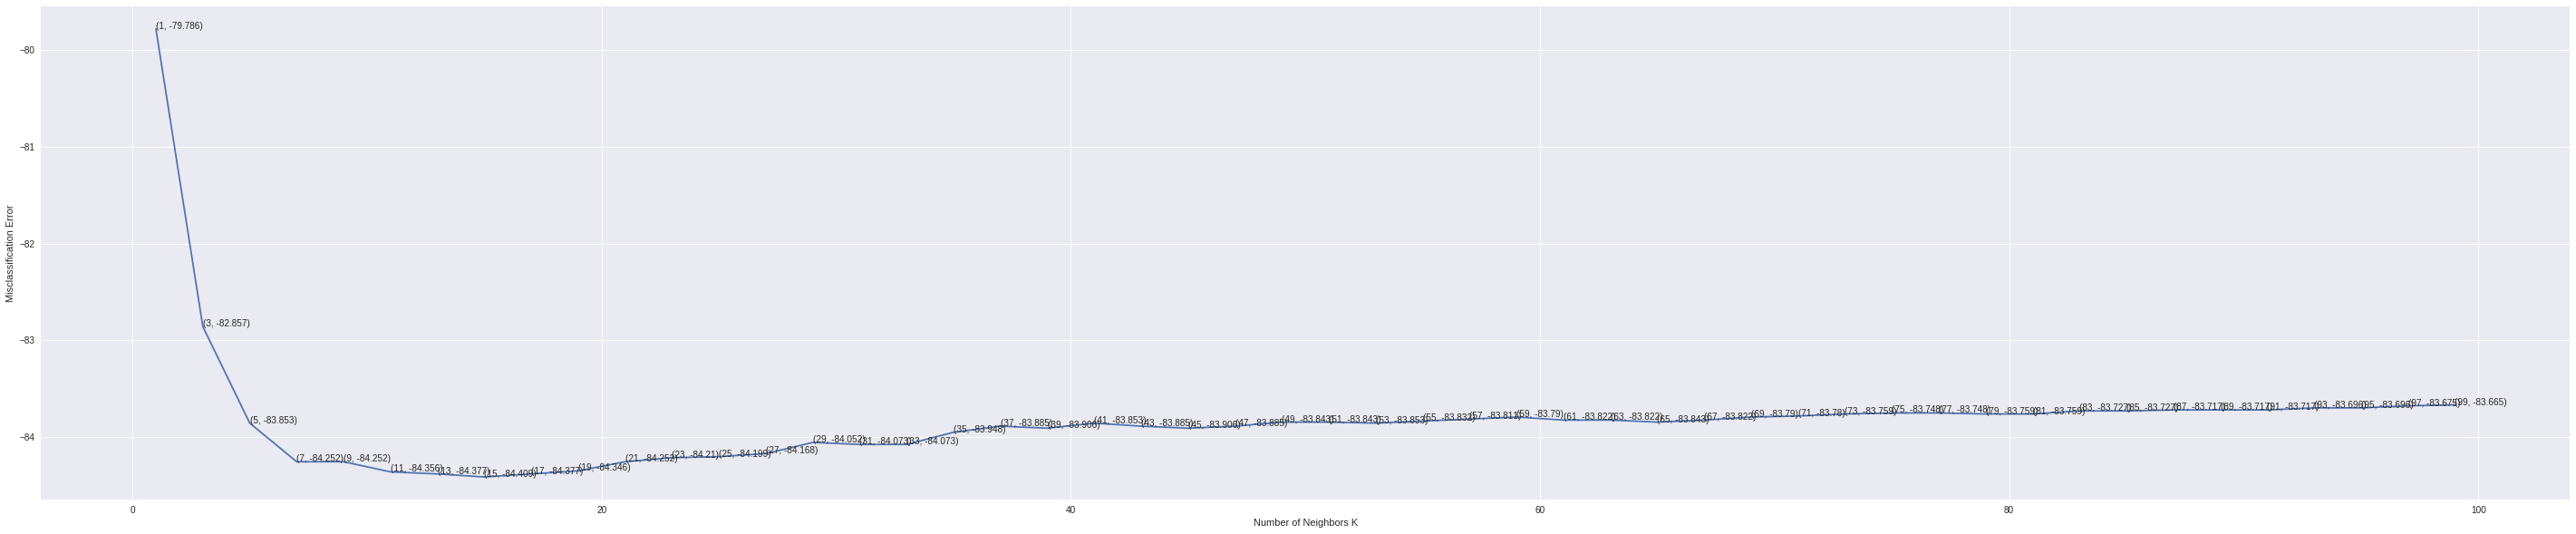

the misclassification error for each k value is :  [-79.786 -82.857 -83.853 -84.252 -84.252 -84.356 -84.377 -84.409 -84.377
 -84.346 -84.252 -84.21  -84.199 -84.168 -84.052 -84.073 -84.073 -83.948
 -83.885 -83.906 -83.853 -83.885 -83.906 -83.885 -83.843 -83.843 -83.853
 -83.832 -83.811 -83.79  -83.822 -83.822 -83.843 -83.822 -83.79  -83.78
 -83.759 -83.748 -83.748 -83.759 -83.759 -83.727 -83.727 -83.717 -83.717
 -83.717 -83.696 -83.696 -83.675 -83.665]


In [172]:
plt.figure(figsize=(50,10))
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')


plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

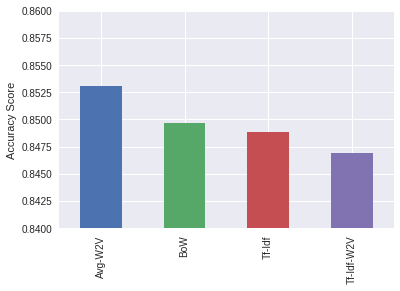

In [170]:
knn_model_accuracy = {
    'BoW': 0.84965,
    'Tf-Idf': 0.84889,
    'Avg-W2V': 0.85311,
    'Tf-Idf-W2V': 0.84689
}

pd.Series(knn_model_accuracy).plot(kind='bar')
plt.ylabel('Accuracy Score')
plt.ylim((0.84, 0.86));